In [108]:
#-----------------------------
# Packages Import
#-----------------------------
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt
import os


In [109]:
#-----------------------------
# Imports a Test Image 
#-----------------------------
FullPathOnLocalMachine= "C:\\Users\\usuario\\Desktop\\Knot-Images-to-regina-code\\data\\Test-Knot.jpg"
print(FullPathOnLocalMachine)

C:\Users\usuario\Desktop\Knot-Images-to-regina-code\data\Test-Knot.jpg


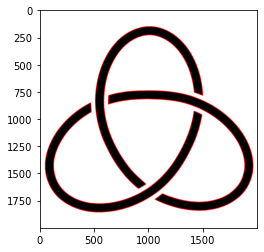

In [110]:
'''
This code will find the countours of the link as a jpg image
'''


image= cv2.imread(FullPathOnLocalMachine)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur and threshold to isolate the knot
blurred = cv2.GaussianBlur(gray, (15, 15), 0)

_, thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_with_countours=cv2.drawContours(image, contours, -1, (255,0,0), 5)
#plt.imshow(thresh)
plt.imshow(image_with_countours)

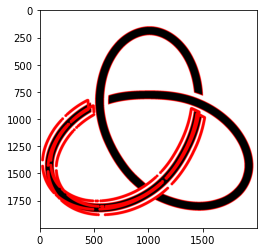

In [111]:
'''
This code makes rectangles along the Knot to process whether is an overcrossing or undercrossing
'''
#The number N is the resolution of the rectangle that we will consider
# It is the minimal resolution of the crossing, this depends on the image
# and posiibly we will need a code to stablish the best N
N=200
rect_size=50

'''
Notes for today: 
-This code seems to work, but there is an issue with the Hierarchy of the countours 
some of the are not acceced via the method below. Read on the CV2 documentation. 
- The code is note efficient and just processing the below picture stores a lot of memory (my computer is getting slow)
'''


rects = []
# Sample points along the contour to place rectangles
#print(countours[::N])
#print(f'The lengh of countours is {len(countours)} and the lenght of stepping every 50 is {len(countours[::50])}')
for component in countours: 
    for point in component[::N] :  # Adjust step for density
        #print(f'The point is {point[0]}')
        x, y = point
        # Center the rectangle on the border point
        #rects.append([[x - rect_size//2, y - rect_size//2],[x + rect_size//2, x + rect_size//2]])
        rects.append([[x - rect_size//2, y - rect_size//2]])
        rects.append([[x + rect_size//2, y + rect_size//2]])

    
rects=np.array(rects)    
image_with_rects=cv2.drawContours(image, rects, -1, (255,0,0), 25)
plt.imshow(image_with_rects)
